## **4. COVID-19 analysis**  

-  Train, Prediction, and Calculate TF Activity  

In this tutorial, we demonstrate how to use publicly available paired scRNA and scATAC data to predict scATAC profiles for unpaired samples that only have scRNA data, and to calculate and analyze transcription factor (TF) activity across different sample conditions in the dataset.

We use a publicly available 10x Genomics Multiome dataset from a healthy donor of human peripheral blood mononuclear cells (PBMCs) (PBMC10k) as training data. This model is used to predict scATAC profiles for unpaired scRNA data from COVID-19-infected donors,it has been annotated cell types and batch information. We first performed batch correction on these samples and the public PBMC data using the Harmony tool, resulting in batch-corrected cell embeddings stored in `RNA.obsm['X_pca_harmony']`. The processed COVID-19 scRNA data and the paired PBMC10k scRNA and scATAC data (filtered using a 1% threshold for PBMC10k) have been uploaded to https://doi.org/10.5281/zenodo.16959682. For detailed procedures, please refer to https://github.com/Miaoyuanyuan777/XChrom_analysis.

- **Data Preprocessing**  
In this tutorial, we use the paired PBMC10k data as the training set to train the model, then predict scATAC profiles for the COVID-19 data. For the training scATAC data, we split it by cells and peaks to generate training/validation data for model input, following the same procedure as in the `1_within-sample` tutorial. For the scRNA data, we directly use the processed batch-corrected cell embeddings (`RNA.obsm['X_pca_harmony']`) as input for model training and prediction.

- **Model Training**  
During training, the model accepts two types of inputs: ① DNA sequences (one-hot encoded, 1 × sequence length) and ② cell embeddings (cell number × embedding dimension matrix). The model is trained to predict sequence accessibility across cells. Importantly, the cell embeddings used here are derived from batch-corrected scRNA-seq data from both samples.

- **Model Prediction**  
After training, we use the COVID-19 `RNA.obsm['X_pca_harmony']` as model input for prediction. Note: Since the COVID-19 data lacks paired scATAC measurements, we can only predict the accessibility of the training set sequences in each COVID-19 cell.

### 1. Download Data (PBMC10k, COVID-19)

-   The original PBMC10k data is available at:  
    [https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_granulocyte_sorted_10k/pbmc_granulocyte_sorted_10k_filtered_feature_bc_matrix.h5](https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_granulocyte_sorted_10k/pbmc_granulocyte_sorted_10k_filtered_feature_bc_matrix.h5)  
    The original COVID-19 data is available at:  
    [https://nubes.helmholtz-berlin.de/s/wqg6tmX4fW7pci5/download](https://nubes.helmholtz-berlin.de/s/wqg6tmX4fW7pci5/download)  
    We have preprocessed this data, which included filtering the paired PBMC10k data and extracting only the scRNA data from mild and severe donor samples in the COVID-19 dataset for analysis. Batch correction was also applied. The preprocessed data can be downloaded from the https://doi.org/10.5281/zenodo.16959682.

-   Download the PBMC10k data and save it as:  
    `'./data/4_pred_newCondition/pbmc10k_atac.h5ad'`  
    `'./data/4_pred_newCondition/pbmc10k_rna_harmony.h5ad'`  
    (These files will be used for model training)

-   Download the COVID-19 data and save it as:  
    `'./data/4_pred_newCondition/covid_rna_harmony.h5ad'`  
    (This file provides the model input for analysis)

-   Download the motif database file from:  
    [https://meme-suite.org/meme/meme-software/Databases/motifs/motif_databases.12.27.tgz](https://meme-suite.org/meme/meme-software/Databases/motifs/motif_databases.12.27.tgz)  
    After decompression, select the file `motif_databases/CIS-BP_2.00/Homo_sapiens.meme` and save it to:  
    `'./data/4_pred_newCondition/Homo_sapiens.meme'`

-   Download the human genome file from:  
    [https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz](https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz)  
    and decompress it.

-   The raw batch-corrected cell embeddings are stored in `RNA.obsm['X_pca_harmony']`, and cell type labels are available in `RNA.obs['celltypeL0']`.

In [1]:
import scanpy as sc
import xchrom as xc

In [2]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="3,2,1,0"  

### 2. train/test data prepare

In [3]:
## generate data for model training
train_folder = './data/4_pred_newCondition/train_data/'
input_fasta = '/picb/bigdata/project/miaoyuanyuan/hg38.fa'
train_atac = sc.read_h5ad('./data/4_pred_newCondition/pbmc10k_atac.h5ad')
dict = xc.pp.process_train_test_single(
    ad_atac=train_atac, ## can be a str, Path, or anndata.AnnData object
    input_fasta=input_fasta,
    output_path=train_folder
)

train/test data is saved in:  data/4_pred_newCondition/train_data
successful writing bed file.
successful writing train/test split file.
successful writing train/test anndata file.
successful writing sparse m.
Successfully saving all sequence h5 file...
Successfully saving trainval sequence h5 file...
Successfully saving test sequence h5 file...


We performed preprocessing on the filtered PBMC10k scATAC:

Following the same procedure as in the `1_Within-sample` tutorial, we partitioned the data using 90% of cells and 90% of peaks to generate training/validation sets. This produced:
- `ad_trainval.h5ad`: containing training cells and training peaks
- `m_trainval.npz`: corresponding count matrix
- `trainval_seqs.h5`: base sequence file for training peaks                 

All files were saved in `'./data/4_pred_newCondition/train_data/'`.

Note: The `input_fasta` parameter should be replaced with the path to the genome file corresponding to the species used in your specific dataset.

### 3. train the model

We use the preprocessed data from the PBMC10k training set obtained above as sequence inputs for the model. The `input_folder` should contain all files generated during preprocessing. The batch-corrected `X_pca_harmony` embeddings derived from scRNA data are used as raw cell embeddings and serve as cell identity inputs to the model. If using dimensionality reduction results from other methods, they must be stored in `cell_embedding_ad.obsm` under the key `cellembed_raw` for extraction.

If you wish to compute NS and LS for model parameters at every training epoch, you need to set `trackscore = True` and specify the `celltype` in either the RNA or ATAC H5AD file. The model is set to train for 1000 epochs by default, but an early stopping mechanism will be triggered if the increase in training auROC remains below 1e-6 for 50 consecutive epochs. The `save_freq` parameter determines the frequency of saving model parameters, with a default value of 1000 (meaning intermediate model parameters are not saved during training).

In [4]:
history = xc.tr.train_XChrom(
    input_folder='./data/4_pred_newCondition/train_data/',
    cell_embedding_ad='./data/4_pred_newCondition/pbmc10k_rna_harmony.h5ad',
    cellembed_raw='X_pca_harmony',
    out_path='./data/4_pred_newCondition/train_out/',
    epochs = 1000,
    verbose = 1
)

=== Start training XChrom model ===
Input folder: /picb/bigdata/project/miaoyuanyuan/train/XChrom_test/XChrom/source/Tutorials/data/4_pred_newCondition/train_data
Cell embedding file: /picb/bigdata/project/miaoyuanyuan/train/XChrom_test/XChrom/source/Tutorials/data/4_pred_newCondition/pbmc10k_rna_harmony.h5ad
Raw cell embedding key: X_pca_harmony
Output path: /picb/bigdata/project/miaoyuanyuan/train/XChrom_test/XChrom/source/Tutorials/data/4_pred_newCondition/train_out
Model parameters: bottleneck=32, batch_size=128, lr=0.01
1. Load raw cell embedding and make z-score normalization...
Raw cell embedding saved to: /picb/bigdata/project/miaoyuanyuan/train/XChrom_test/XChrom/source/Tutorials/data/4_pred_newCondition/pbmc10k_rna_harmony.h5ad.obsm['X_pca_harmony']
Initial cell embedding saved to: /picb/bigdata/project/miaoyuanyuan/train/XChrom_test/XChrom/source/Tutorials/data/4_pred_newCondition/pbmc10k_rna_harmony.h5ad.obsm['zscore32_perpc']
Initial cell embedding shape: (11898, 32)
2. Lo

2025-08-18 15:11:33.141411: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-18 15:11:34.846821: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21971 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:b1:00.0, compute capability: 8.6
2025-08-18 15:11:34.847782: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 21971 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:98:00.0, compute capability: 8.6
2025-08-18 15:11:34.848213: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:l

5. Build and compile model...
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence (InputLayer)           [(None, 1344, 4)]    0                                            
__________________________________________________________________________________________________
stochastic_reverse_complement ( ((None, 1344, 4), () 0           sequence[0][0]                   
__________________________________________________________________________________________________
stochastic_shift (StochasticShi (None, 1344, 4)      0           stochastic_reverse_complement[0][
__________________________________________________________________________________________________
gelu (GELU)                     (None, 1344, 4)      0           stochastic_shift[0][0]           
________________________________________________________________

2025-08-18 15:11:40.845523: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2025-08-18 15:11:46.107242: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8800
2025-08-18 15:11:46.221853: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


641/641 [==============================] - 229s 340ms/step - loss: 0.2488 - binary_accuracy: 0.9157 - auc: 0.7736 - pr: 0.2814 - val_loss: 0.2395 - val_binary_accuracy: 0.9172 - val_auc: 0.7982 - val_pr: 0.3480
Epoch 2/1000
641/641 [==============================] - 215s 327ms/step - loss: 0.2334 - binary_accuracy: 0.9187 - auc: 0.7965 - pr: 0.3500 - val_loss: 0.2456 - val_binary_accuracy: 0.9172 - val_auc: 0.7948 - val_pr: 0.3396
Epoch 3/1000
641/641 [==============================] - 214s 330ms/step - loss: 0.2316 - binary_accuracy: 0.9194 - auc: 0.8008 - pr: 0.3593 - val_loss: 0.2433 - val_binary_accuracy: 0.9177 - val_auc: 0.8000 - val_pr: 0.3625
Epoch 4/1000
641/641 [==============================] - 227s 345ms/step - loss: 0.2298 - binary_accuracy: 0.9203 - auc: 0.8046 - pr: 0.3688 - val_loss: 0.2444 - val_binary_accuracy: 0.9173 - val_auc: 0.8035 - val_pr: 0.3603
Epoch 5/1000
641/641 [==============================] - 221s 337ms/step - loss: 0.2287 - binary_accuracy: 0.9205 - au

Plotting training metrics helps monitor overfitting and evaluate the final model performance. Ideally, after a certain number of epochs, the metric curves should stabilize and remain steady.

The metrics computed during training are saved in `./data/4_pred_newCondition/train_out/history.pickle`. They can be loaded using the following code:

```python
import pickle
with open('./data/4_pred_newCondition/train_out/history.pickle', 'rb') as f:
    history = pickle.load(f)
```

This `history` object contains all training metrics (loss, auROC, auPRC, etc.) recorded during the training process, which can be used to generate plots and analyze model performance.  

The function `plot_train_history()` will automatically detect whether NS and LS values have been computed during training. If these metrics are available in the history data, they will be automatically included in the training metric plots along with other evaluation metrics such as loss, auROC, and auPRC. 

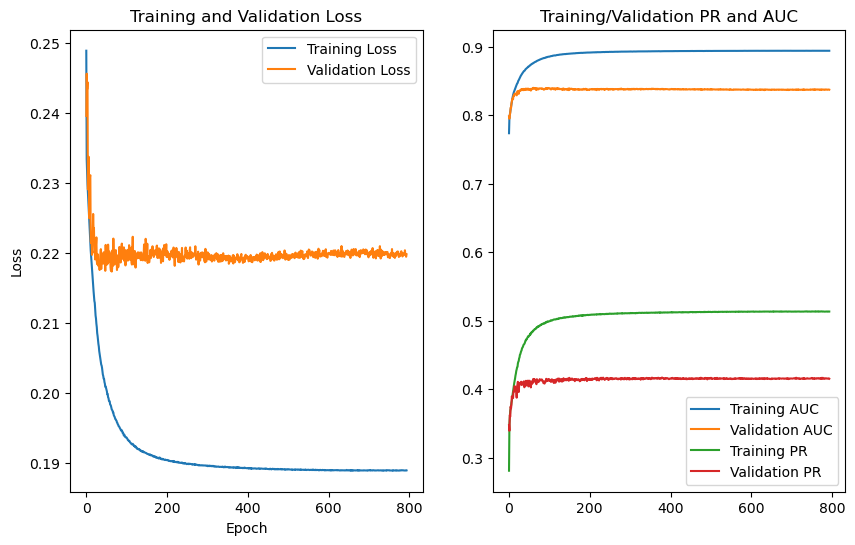

In [5]:
xc.pl.plot_train_history(
    history = history['history'],
    savefig = True,
    out_file = './data/4_pred_newCondition/train_out/train_history_plot.pdf'
    )

### 4. calculate TF activity
We performed motif insertion on trained XChrom to compute a TF activity score for each TF for each cell. 

Specifically, we first generate 1,000 genomic background sequences by performing dinucleotide shuffling of 1,000 randomly sampled peaks from the training sequences atlas using `fasta ushuffle`. For each TF in the motif database, we sampled a motif sequence from the PWM and inserted it into the center of each of the genomic background sequences. We ran forward passes through the model for both the motif-inserted sequences and background sequences to predict accessibility across all cells, making difference as the motif influence for each sequence. We average this influence score across all 1,000 sequences for each cell to generate a cell-level prediction of raw TF activity. 

- for this，you must install fasta_ushuffle first with: `conda install bioconda::fasta_ushuffle`

In [6]:
seq_path = xc.tl.generate_tf_activity_data(
    bed_file = './data/4_pred_newCondition/train_data/peaks.bed',  ## to generate background sequence
    input_fasta = '/picb/bigdata/project/miaoyuanyuan/hg38.fa',
    motif_file = './data/4_pred_newCondition/Homo_sapiens.meme',
    output_dir = './data/4_pred_newCondition/motif_fasta/',
    n_samples = 1000,
    n_motif_instances = 1000)

=== Start preparing motif data ===
1. Read BED file: ./data/4_pred_newCondition/train_data/peaks.bed
Sampled 1000 regions from ./data/4_pred_newCondition/train_data/peaks.bed
2. Extract background sequences...
Extracting sequences from BED file...
Reference genome: /picb/bigdata/project/miaoyuanyuan/hg38.fa
Sequence length: 1344
Consider strand information: False
Successfully extracted 1000 sequences
Writing to FASTA file: data/4_pred_newCondition/motif_fasta/ref_peaks1000.fasta
FASTA file saved to: data/4_pred_newCondition/motif_fasta/ref_peaks1000.fasta
Number of sequences written: 1000
Extracted 1000 sequences, saved to data/4_pred_newCondition/motif_fasta/ref_peaks1000.fasta
3. Generate shuffled background sequences...
Using fasta_ushuffle from: /home/miaoyuanyuan/miniconda3/envs/py3.8_tf2.6.0/bin/fasta_ushuffle
Dinucleotide shuffled 1000 sequences, saved to data/4_pred_newCondition/motif_fasta/shuffled_peaks.fasta
4. Read motif file(meme format)...
Read 1065 motifs from ./data/4_p

Processing motifs: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1065/1065 [04:59<00:00,  3.56it/s]

=== motif data preparation completed ===
Background sequence file: data/4_pred_newCondition/motif_fasta/shuffled_peaks.fasta
Motif inserted sequence directory: data/4_pred_newCondition/motif_fasta/shuffled_peaks_motifs


Note: Since the COVID-19 data lacks paired scATAC data, background sequences can only be sampled from the training set sequences. 

In [8]:
covid_rna = sc.read_h5ad('./data/4_pred_newCondition/covid_rna_harmony.h5ad')
tf_act = xc.tl.calc_tf_activity(
    motif_dir = './data/4_pred_newCondition/motif_fasta/shuffled_peaks_motifs/',
    background_fasta = './data/4_pred_newCondition/motif_fasta/shuffled_peaks.fasta',
    model_path = './data/4_pred_newCondition/train_out/E1000best_model.h5',
    ad_rna = covid_rna,
    output_file = './data/4_pred_newCondition/analysis_out/tf_activity.h5ad',
    cell_embed_raw = 'X_pca_harmony',
    regenerate_motif_h5 = True,
    regenerate_bg_h5 = True)

=== Start calculating TF Activity ===
1. Prepare raw cell embedding...
2. Generate motif insertion sequence h5 files...


Generating H5 files: 100%|██████████████████████████████████████████████████████████████████████████████████████| 1065/1065 [06:56<00:00,  2.56it/s]


Found 1065 motif files
3. Generate background sequence h5 file...
Generating background sequence h5 file...
4. Prepare data for XChrom model input...
Converting adata.X to dense array. For large datasets, consider pre-computing and saving as sparse matrix.
5. Load trained model...
6. Calculate background sequence prediction...
7. Calculate motif insertion scores...
Processing 1065 motif files...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1065/1065 [5:00:22<00:00, 16.92s/it]


8. Save results...
=== Done! Results saved to: data/4_pred_newCondition/analysis_out/tf_activity.h5ad ===
TF activity matrix shape: (90312, 1065) (cells × motifs)


Note: This process will take a long time

If you do not need to calculate activities for all motifs, you can keep only the motif files you require in the `motif_dir`. 

Set `regenerate_bg_h5=False` if you have already generated the background sequences in H5 format,
Set `regenerate_motif_h5=False` if you have already generated H5 files for each motif

### 5. Check TF activity in different cell types

In [9]:
covid_rna = sc.read_h5ad('./data/4_pred_newCondition/covid_rna_harmony.h5ad')
tf_act = sc.read_h5ad('./data/4_pred_newCondition/analysis_out/tf_activity.h5ad')

Plot saved to: ./CEBPB_activity.pdf


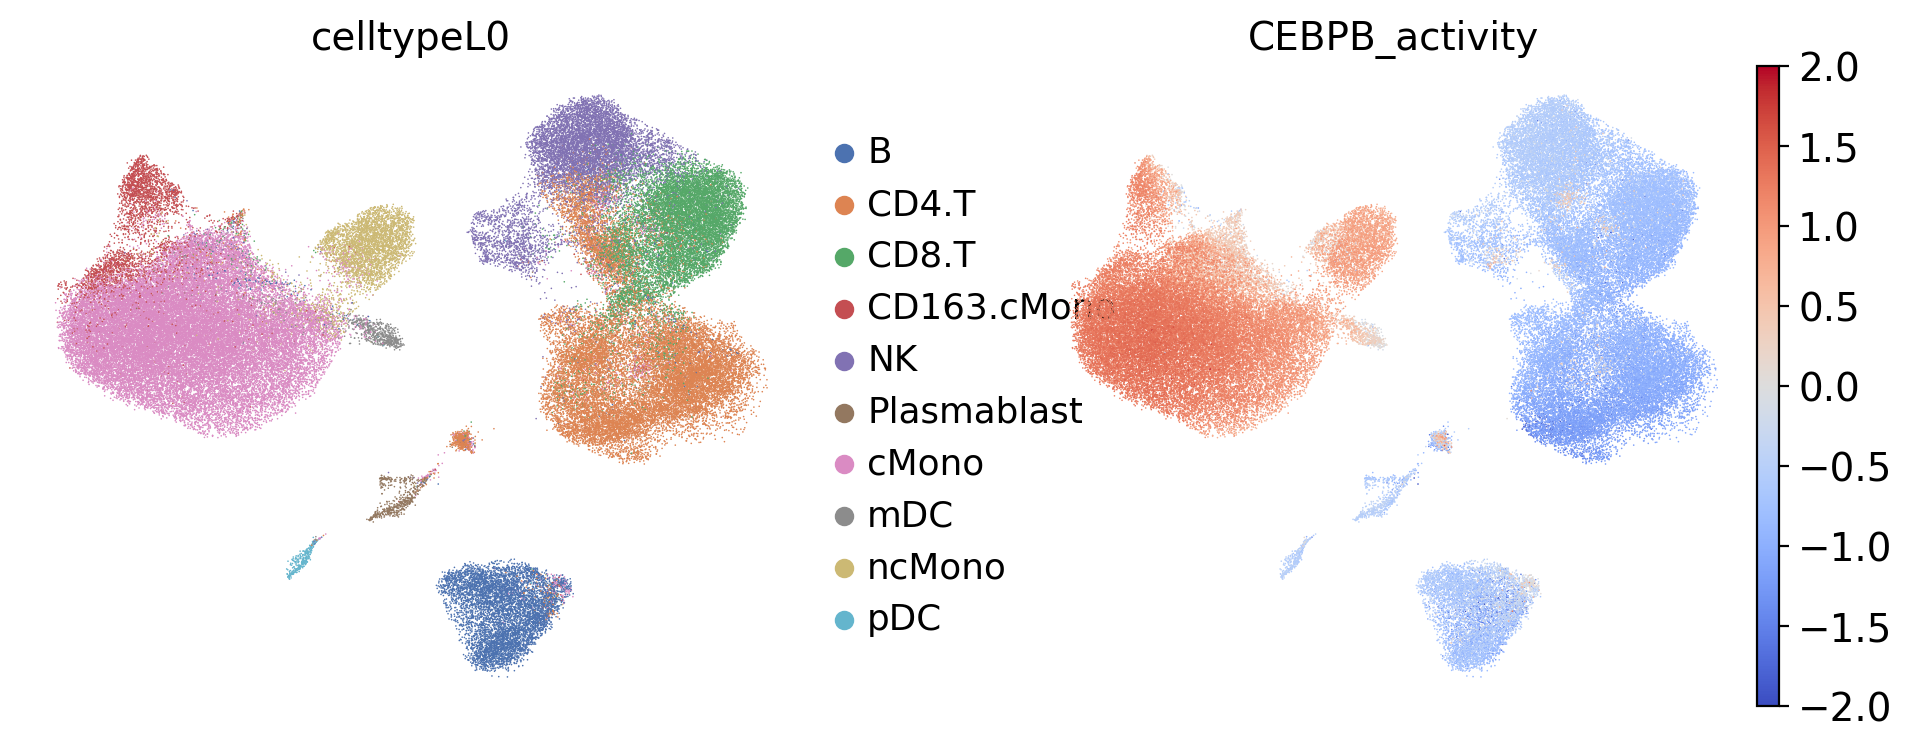

In [10]:
xc.pl.plot_motif_activity(
    cell_embedding_ad = covid_rna,
    celltype_key = 'celltypeL0',
    tf_act_raw = tf_act,
    motif_name = 'CEBPB',
    save_path = './CEBPB_activity.pdf'
)

The `plot_motif_activity()` function performs z-score normalization of the calculated TF activities across cell types. In the resulting visualization:
- **Red** indicates that CEBPB shows relatively higher activity in that cell type
- **Blue** indicates relatively lower activity

This normalization allows for clear comparison of transcription factor activity patterns across different cell types and conditions.